# Computer Vision (Winter 2019/20)

## Practice Session 07

December 1st, 2020

Axel Schaffland, Ulf Krumnack

Institute of Cognitive Science
University of Osnabrück

## Today's Session

* Down- and upsampling, pyramids
* Gradient images

<IPython.core.display.Javascript object>


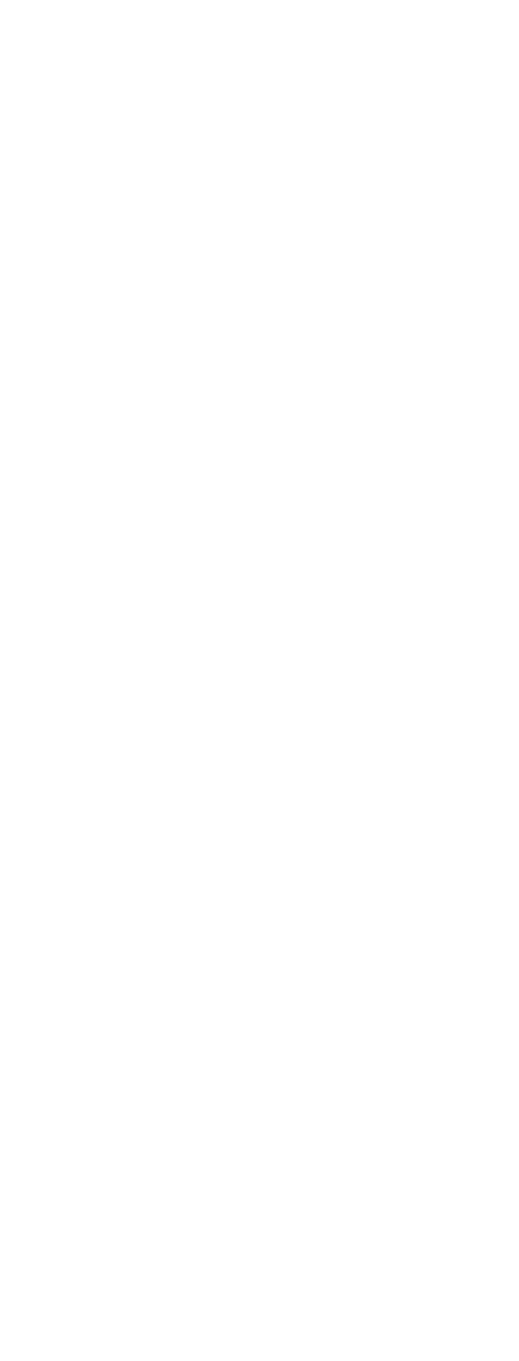

<IPython.core.display.Javascript object>


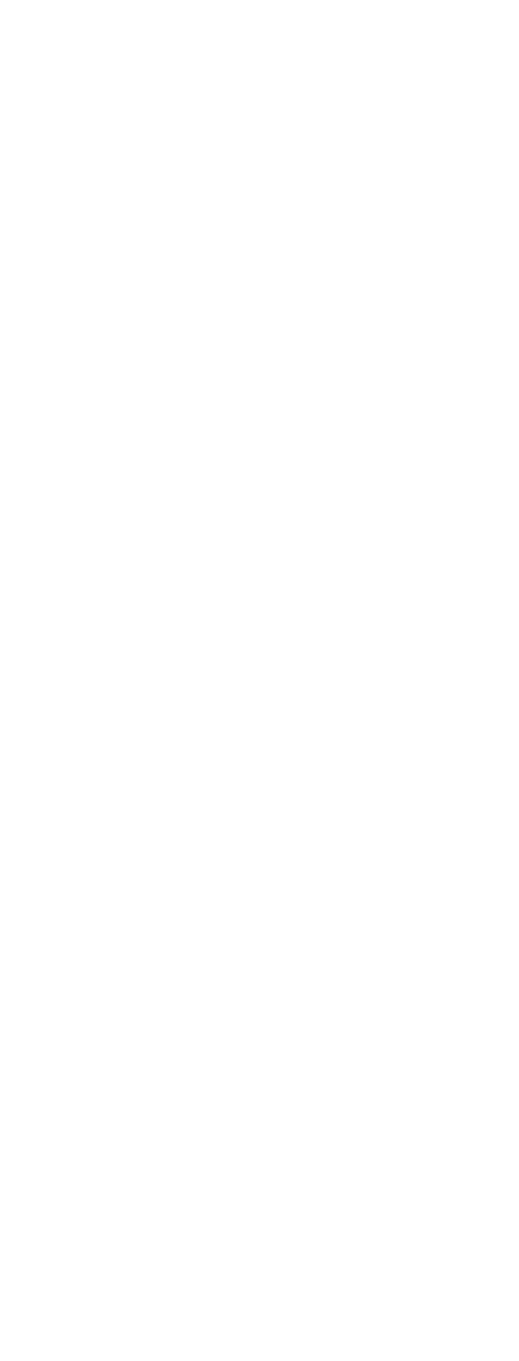

In [16]:
%matplotlib notebook
import imageio
import numpy as np
from skimage.color import rgb2gray
from scipy.ndimage import convolve
from matplotlib import pyplot as plt, patches
from ipywidgets import interactive, fixed, Dropdown

image = rgb2gray(imageio.imread('imageio:chelsea.png'))


def build_pyramid(image, filter=np.asarray([1.,4.,6.,4.,1.])):
    
    if filter is not None:
        filter /= filter.sum()
        if len(filter.shape) == 1:
            filter = filter.reshape(1,-1)
            filter = filter.T @ filter

    pyramid = [image]
    minimal_size = 5 if filter is None else len(filter)
    while min(image.shape) >= minimal_size:
        image = pyramid[-1]
        if filter is not None:
            image = convolve(image, filter, mode='constant')
        image = image[::2,::2]
        pyramid.append(image)
    return pyramid

pyramid1 = build_pyramid(image)
pyramid2 = build_pyramid(image, filter=None)

columns = 2
rows = len(pyramid1)
fig_width = 8
fig_height = (rows * fig_width * image.shape[0]) // (columns * image.shape[1])
fig, ax = plt.subplots(rows, columns, figsize=(fig_width, fig_height))
plt.gray()

for level, (image1, image2) in enumerate(zip(pyramid1, pyramid2)):
    ax[level,0].set_title(f"Image {level} with filtering {image1.shape}")
    ax[level,0].imshow(image1)
    ax[level,1].set_title(f"Image {level} without filtering {image2.shape}")
    ax[level,1].imshow(image2)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


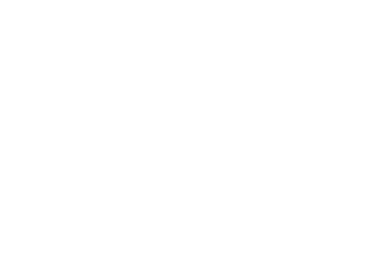

<IPython.core.display.Javascript object>


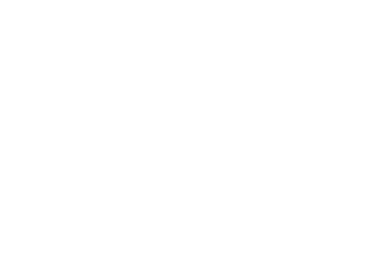

In [17]:
def stack_images(pyramid):
    """Stack all images of an image pyramid into one image.
    
    Arguments
    ---------
    pyramid: List[np.ndarray]
        The images of the pyramid in decreasing size.
        
    Result
    ------
    result: np.ndarray
        The resulting image, having the size of the largest
        image in the pyramid.
    """
    result = np.ndarray(pyramid[0].shape)
    for image in pyramid:
        result[:image.shape[0],:image.shape[1]] = image
    return result

stacked = stack_images(pyramid1)

plt.figure()
plt.imshow(stacked)
plt.show()

<IPython.core.display.Javascript object>


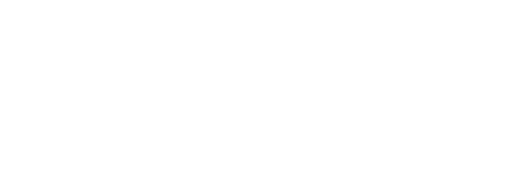

<IPython.core.display.Javascript object>


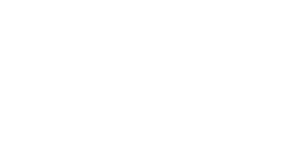

In [18]:
import itertools
from scipy.ndimage import convolve

def expand(image):
    """The expand operation from CV-07, slide 33.
    
    Arguments
    ---------
    image: np.ndarray
        The image to be exanded

    Result
    ------
    expanded: np.ndarray
        The expanded image
    """
    filter = [np.asarray([1,6,1])/8, np.asarray([4, 4])/8.]
    expanded = np.zeros((image.shape[0]*2, image.shape[1]*2))
    for dx,dy in itertools.product((0,1), (0,1)):
        kernel = filter[dx].reshape(-1,1) @ filter[dy].reshape(1,-1)
        expanded[dx::2,dy::2] = convolve(image, kernel)
    return expanded

image = pyramid1[3]
expanded = expand(image)
        
fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].set_title("Downscaled image")
ax[0].imshow(image)

ax[1].set_title("Expanded image")
ax[1].imshow(expanded)

plt.show()

<IPython.core.display.Javascript object>


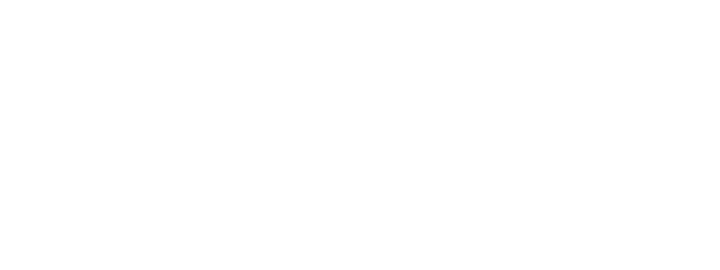

In [4]:
%matplotlib notebook
import itertools
import imageio
import numpy as np
from matplotlib import pyplot as plt, patches
from ipywidgets import interactive, fixed, Dropdown

marker = patches.Rectangle((-.5, -.5), 1, 1, fill=False, snap=False, edgecolor='g')
marker2 = patches.Rectangle((-.5, -.5), 1, 1, fill=False, snap=False, edgecolor='g', lw=3)
boxes = []

def set_boxes(position):
    global boxes
    
    # set target box
    marker.set_xy((position[0]-.5, position[1]-.5))
    marker2.set_xy((position[0]/2-.5, position[1]/2-.5))
    
    # remove old boxes
    for box in boxes:
        box.remove()
    boxes = []
    
    # create new boxes
    x_offsets = (-1,0,1) if position[0]%2 == 0 else (-.5,.5)
    y_offsets = (-1,0,1) if position[1]%2 == 0 else (-.5,.5)
    x, y = position[0]/2, position[1]/2
    for dx, dy in itertools.product(x_offsets, y_offsets):
        box = patches.Rectangle((x+dx-.5, y+dy-.5), 1, 1,
                                fill=False, snap=False, edgecolor = 'r')
        ax[0].add_patch(box)
        boxes.append(box)

def on_press(event):
    """Mouse button press event handler. Move the zoom to another image location
    
    Args:
        event: The mouse event
    """
    x, y = int(event.xdata), int(event.ydata)
    if event.inaxes == ax[0]:
        set_boxes((x*2, y*2))
        ax[0].set_title(f"Pixel at ({x}, {y})")
        ax[1].set_title("")
    elif event.inaxes == ax[1]:
        set_boxes((x, y))
        ax[0].set_title("")
        ax[1].set_title(f"Pixel at ({x}, {y})")

    fig.canvas.draw()

pyramid = pyramid2
level = 5
full = True

image = pyramid[6]
if full:
    expanded = expand(image)
else:
    image_upscaled = np.zeros((image.shape[0]*2, image.shape[1]*2))
    image_upscaled[::2,::2] = image

fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].imshow(image)
ax[0].add_patch(marker2)

ax[1].imshow(expanded)
ax[1].add_patch(marker)
set_boxes((4,4))
cid = fig.canvas.mpl_connect('button_press_event', on_press)
plt.show()

### Matplotlib interpolation 

Matplotlib offers a series of [interpolation methods](http://matplotlib.org/examples/images_contours_and_fields/interpolation_methods.html) for displaying images.
From the [docs](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow):

> If interpolation is None, default to rc image.interpolation. See also
> the filternorm and filterrad parameters. If interpolation is 'none', then
> no interpolation is performed on the Agg, ps and pdf backends. Other
> backends will fall back to 'nearest'.

The following cell shows all the different interpolation methods for `imshow`:

Matplotlib default interpolation method is None


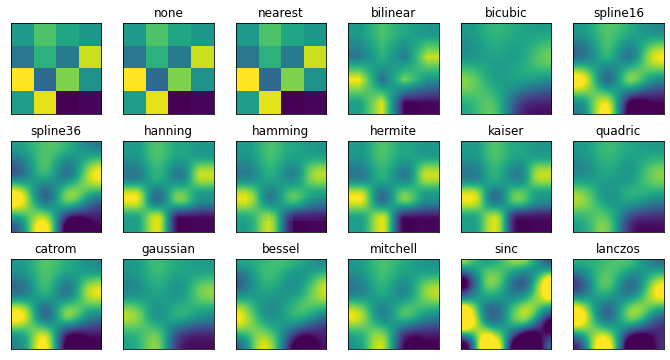

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


print(f"Matplotlib default interpolation method is {plt.rc('image.interpolation')}")
methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

np.random.seed(0)
grid = np.random.rand(4, 4)


fig, axes = plt.subplots(3, 6, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, interp_method in zip(axes.flat, methods):
    ax.imshow(grid, interpolation=interp_method, cmap='viridis')
    ax.set_title(interp_method)

plt.show()

## Image gradients

### Horizontal/Vertical Sobel Filer


**Horizontal Sobel**
$$G_x = \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 1 \\
-1 & 0 & 1 \\
\end{bmatrix}$$

* Horizontal changes/gradient
* Vertical edges

**Vertical Sobel**
$$G_y = \begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1 \\
\end{bmatrix}$$

* Vertical changes/gradient
* Horizontal edges


For horizontal x-axis and vertical y-axis.

In [6]:
# Some auxiliar functions

import matplotlib as mpl
from scipy.signal import convolve2d


def show_image_row(ax, img, row = None, axis = 0):
    """Show an image, highlighting a row.
    """
    ax.imshow(img, interpolation = 'none')
    if row is not None:
        marker_height = ceil(img.shape[0]*.01)
        marker = mpl.patches.Rectangle((0,row-(marker_height//2)), img.shape[1], marker_height, snap=False, edgecolor = 'r', alpha=.3)
        ax.add_patch(marker)

def show_image_row_function(ax, img, row, format = 'r'):
    """Show an image row as function.
    """
    line = img[row,:]
    ax.imshow(line[np.newaxis].repeat(256,0), aspect='auto', origin='lower')
    ax.plot(line, format)

def show_image_and_function(img, row = None):

    plt.figure(figsize=(12,6))
    plt.gray()

    if row is None:
        ax = plt.gca()
    else:
        ax = plt.subplot(1,2,1)
        row = round(row*img.shape[0])

    show_image_row(ax, img, row)

    if row is not None:
        show_image_row_function(plt.subplot(1,2,2), img, row)

    plt.show()

<ipython-input-7-591ac6522535>:10: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img = color.rgb2gray(imageio.imread('imageio:camera.png').astype(np.float))


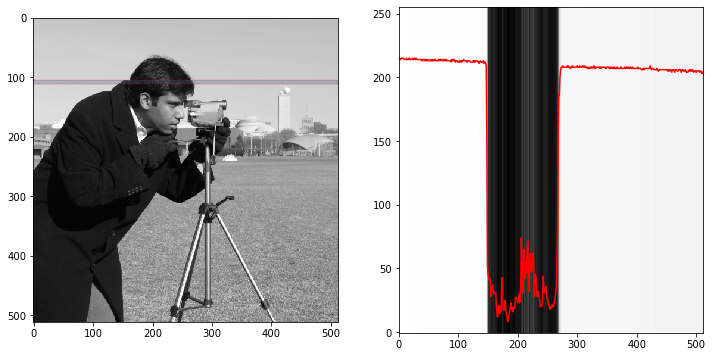

In [7]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage import color
from scipy import ndimage
from math import ceil
import imageio

img = color.rgb2gray(imageio.imread('imageio:camera.png').astype(np.float))
show_image_and_function(img, row = .21)

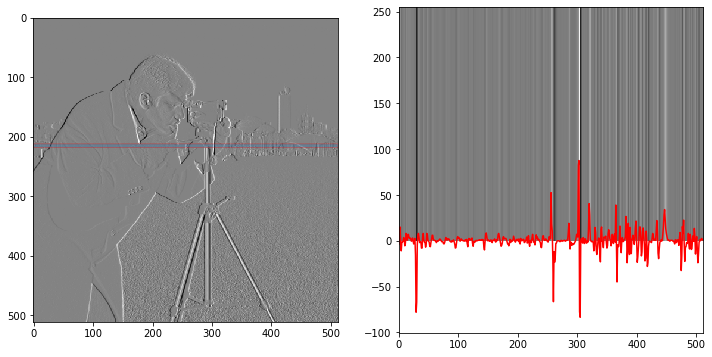

In [8]:
%matplotlib inline
import numpy as np

grad_img = np.gradient(img, axis=1)
show_image_and_function(grad_img, row = .42)

## Computing the gradient image (scikit image)

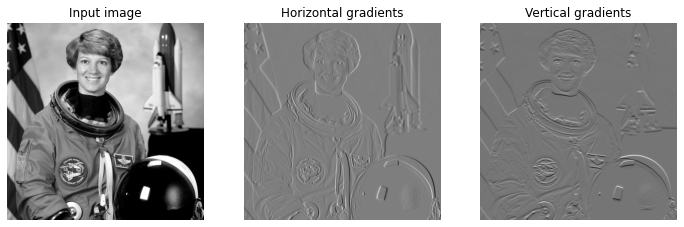

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, exposure, color, filters

image = color.rgb2gray(data.astronaut())
gradient_x = filters.sobel(image, axis=1)
gradient_y = filters.sobel(image, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(gradient_x, cmap=plt.cm.gray)
ax2.set_title('Horizontal gradients')

ax3.axis('off')
ax3.imshow(gradient_y, cmap=plt.cm.gray)
ax3.set_title('Vertical gradients')
plt.show()

From horizontal and vertical gradients we can compute:
* gradient magnitude: $\sqrt{g_x^2+g_y^2}$
* gradient direction: $\arctan\frac{g_y}{g_x}$

In [10]:
gradient_mag = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_angle = np.arctan2(gradient_y, gradient_x)

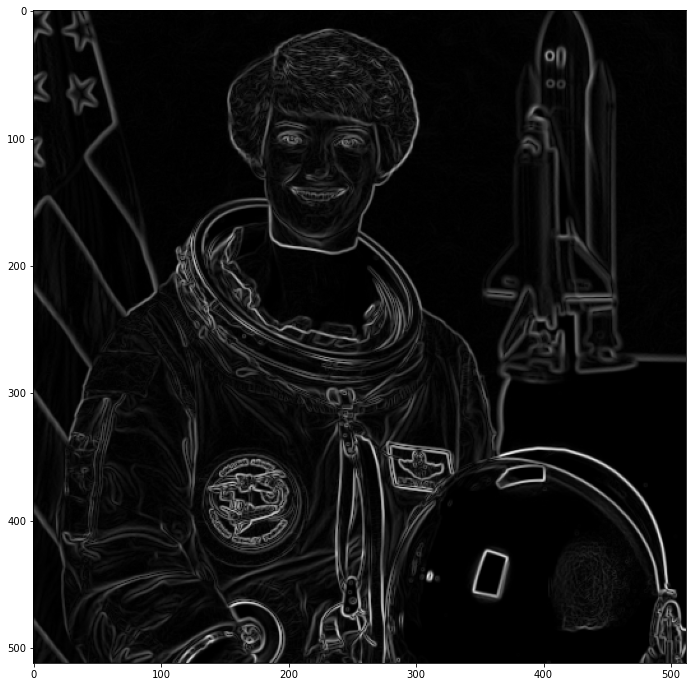

In [11]:
plt.figure(figsize=(12, 12))
plt.gray()
plt.imshow(gradient_mag)
plt.show()

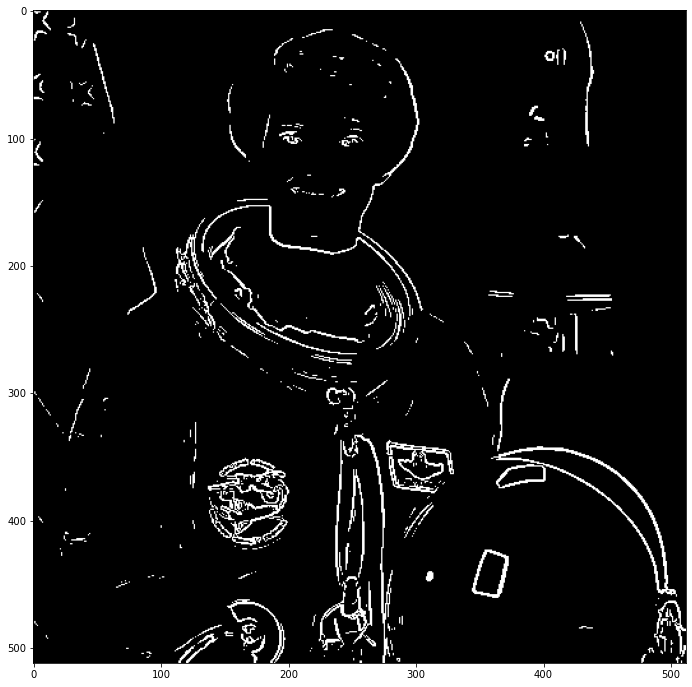

In [12]:
threshold = 0.3 * gradient_mag.max()

plt.figure(figsize=(12, 12))
plt.gray()
plt.imshow(gradient_mag > threshold)
plt.show()

## The gradient direction

In [13]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, filters

def get_quiver_gradient(gradient_x, gradient_y, gradient_mag, grid=(10, 10), threshold=0.3, stretch = 30):
    threshold_mag = threshold * gradient_mag.max()

    X, Y, U, V = [], [], [], []
    for block in np.ndindex(gradient_mag.shape[0]//grid[0], gradient_mag.shape[1]//grid[1]):
        patch = gradient_mag[block[0]:min(block[0]+grid[0],gradient_mag.shape[0]),
                             block[1]:min(block[1]+grid[1],gradient_mag.shape[1])]
        y,x = np.unravel_index(patch.argmax(), patch.shape)
        y += block[0] * grid[0]
        x += block[1] * grid[1]
        if gradient_mag[y,x] > threshold_mag:
            X.append(x)
            Y.append(y)
            U.append(gradient_x[y,x]*stretch)
            V.append(-gradient_y[y,x]*stretch)
    return X, Y, U, V

def plot_gradient_image(ax, image, threshold=0.3, show='magnitude', arrows=True):
    gray_image = color.rgb2gray(image)
    gradient_x = filters.sobel(gray_image, axis=1)
    gradient_y = filters.sobel(gray_image, axis=0)
    gradient_mag = np.sqrt(gradient_x**2 + gradient_y**2)
    
    if arrows:
        X, Y, U, V = get_quiver_gradient(gradient_x, gradient_y, gradient_mag, threshold=threshold)

    global artist_image, artist_quiver
    if show == 'magnitude':
        show_image = gradient_mag
    elif show == 'x':
        show_image = gradient_x
    elif show == 'y':
        show_image = gradient_y
    elif show == 'threshold':
        show_image = gradient_mag > 0.3 * gradient_mag.max()
    elif show == 'original':
        show_image = image
    elif show == 'gray':
        show_image = gray_image
    elif show == 'color':
        # color coded gradient direction
        hsv_image = np.ndarray(shape=gradient_mag.shape + (3,))
        gradient_angle = np.arctan2(gradient_y, gradient_x)
        hsv_image[:,:,0] = (gradient_angle + np.pi) / (2*np.pi)
        # the following may also be swapped:
        hsv_image[:,:,1] = gradient_mag/gradient_mag.max()
        hsv_image[:,:,2] = 1.0
        show_image = color.hsv2rgb(hsv_image)
    else:
        raise ValueError(f"invalid show argument: '{show}'")
    if artist_image is None:
        artist_image = ax.imshow(show_image)
    else:
        artist_image.set_data(show_image)

    if artist_quiver is not None:
        artist_quiver.remove()
        # del quiver_artist
    if arrows:
        artist_quiver = ax.quiver(X, Y, U, V, color='y')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


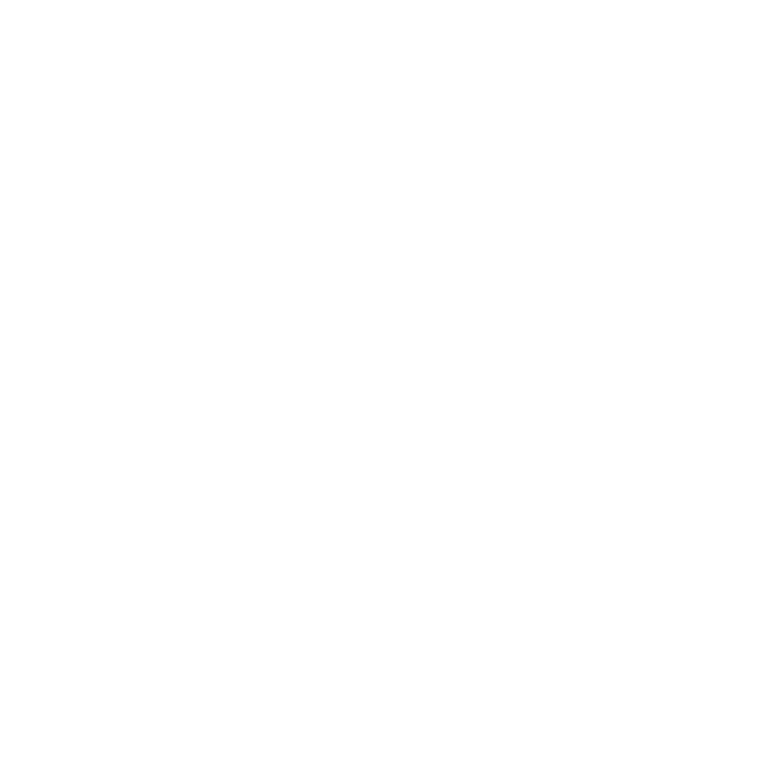

In [14]:
import matplotlib.pyplot as plt
from skimage import data
assert 'plot_gradient_image' in globals(), "Make sure that 'plot_gradient_image' is defined."

artist_image = None
artist_quiver = None
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
plt.gray()
plt.show()

image = data.astronaut()
plot_gradient_image(ax, image, threshold=.2)  # show='original','gray'
fig.canvas.draw()

## Gradient directions as color

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


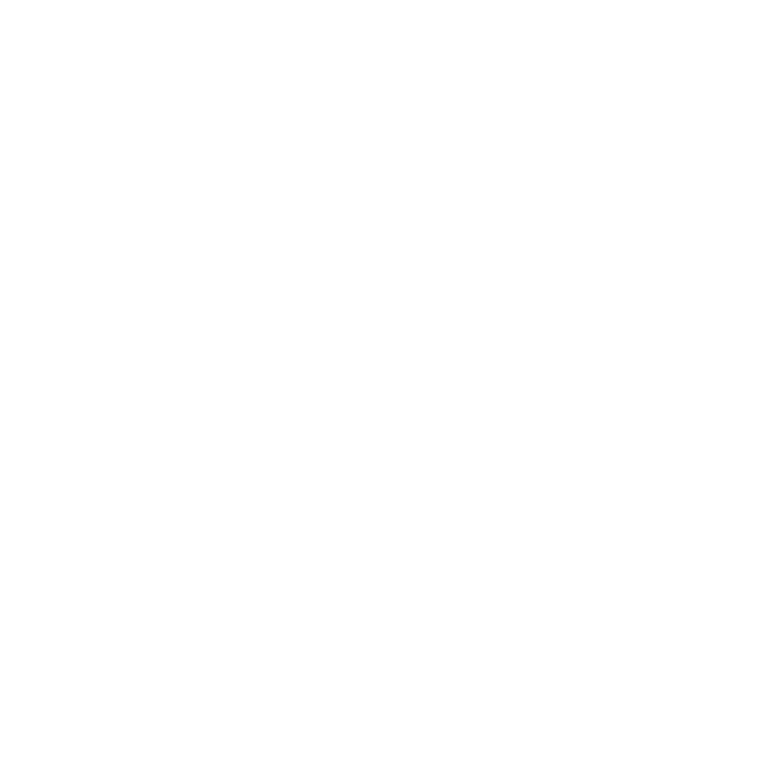

In [15]:
import matplotlib.pyplot as plt
from skimage import data
assert 'plot_gradient_image' in globals(), "Make sure that 'plot_gradient_image' is defined."

artist_image = None
artist_quiver = None
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
plt.gray()
plt.show()

image = data.astronaut()
plot_gradient_image(ax, image, threshold=.2, show='color', arrows=False)
fig.canvas.draw()